In [1]:
# 1. Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
from tqdm import tqdm
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# 2. Path dataset
train_path = "/kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/train"
val_path = "/kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/val/"
test_path = "/kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/test/"

In [3]:
# 3. Get image paths
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

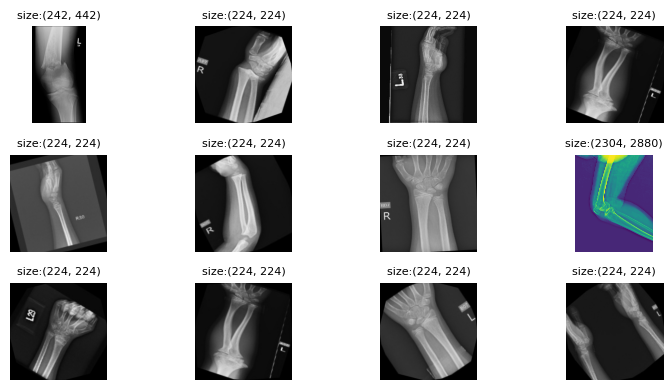

In [4]:
# 4. Display dataset

def display_dataset(path, num_images=12):
    random.seed(322)
    images_paths = get_image_paths(path)
    random_images = random.sample(images_paths, num_images)
    fig, axes = plt.subplots(3, 4, figsize=(8, 4))

    for i, ax in enumerate(axes.flat):
        image_path = random_images[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"size:{image.size}", fontsize=8)

    plt.tight_layout()
    plt.show()

display_dataset(val_path)

In [5]:
# 5. Handle transparency
class HandleTransparency(object):
    def __call__(self, img):
        if img.mode in ['RGBA', 'LA']:
            img = img.convert('L')
        elif img.mode == 'P':
            img = img.convert('RGBA').convert('L')
        else:
            img = img.convert('L')
        return img


In [6]:
# 6. Transforms
train_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [7]:
# 7. Load datasets
train_ds = ImageFolder(train_path, transform=train_transforms)
val_ds = ImageFolder(val_path, transform=val_transforms)

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

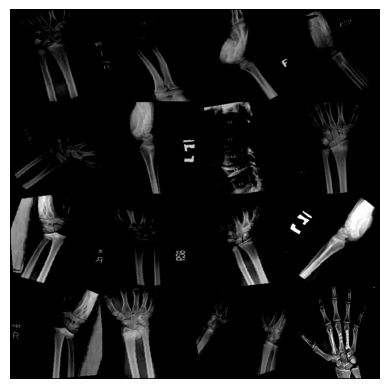

In [8]:
# 8. Show batch images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_dataloader)
images, _ = next(dataiter)
imshow(vutils.make_grid(images[:16], nrow=4))

In [9]:
# 9. Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
# 10. Load MobileNet and modify
model = timm.create_model('mobilenetv2_100.ra_in1k', pretrained=True, num_classes=2)

for param in model.parameters():
    param.requires_grad = False
for param in model.blocks[-1].parameters():
    param.requires_grad = True

model.conv_stem = nn.Conv2d(
    in_channels=1,
    out_channels=model.conv_stem.out_channels,
    kernel_size=model.conv_stem.kernel_size,
    stride=model.conv_stem.stride,
    padding=model.conv_stem.padding,
    bias=(model.conv_stem.bias is not None)
)

in_features = model.get_classifier().in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 2)
)

model = model.to(device)

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [11]:
# 11. Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [12]:
# 12. Training/validation loop
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    acc = 100 * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), acc, all_labels, all_preds

def train(model, train_dl, val_dl, criterion, optimizer, scheduler, epochs=20):
    train_losses, val_losses, accs = [], [], []
    all_labels, all_preds = [], []
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_dl, criterion, optimizer)
        val_loss, acc, labels, preds = validate(model, val_dl, criterion)
        scheduler.step()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accs.append(acc)
        all_labels.extend(labels)
        all_preds.extend(preds)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Acc {acc:.2f}%")
    return train_losses, val_losses, accs, all_labels, all_preds


In [13]:
train_losses, val_losses, accs, all_labels, all_preds = train(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler
)

 31%|███       | 4/13 [00:03<00:08,  1.10it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


Epoch 1: Train Loss 0.6163 | Val Loss 0.5481 | Acc 76.24%


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 2: Train Loss 0.4826 | Val Loss 0.4379 | Acc 82.15%


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 3: Train Loss 0.3856 | Val Loss 0.3479 | Acc 87.45%


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch 4: Train Loss 0.3143 | Val Loss 0.2994 | Acc 89.02%


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch 5: Train Loss 0.2733 | Val Loss 0.2788 | Acc 89.38%


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Epoch 6: Train Loss 0.2410 | Val Loss 0.2593 | Acc 89.51%


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch 7: Train Loss 0.2212 | Val Loss 0.2420 | Acc 90.23%


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch 8: Train Loss 0.2028 | Val Loss 0.2297 | Acc 90.47%


100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch 9: Train Loss 0.1893 | Val Loss 0.2160 | Acc 91.19%


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch 10: Train Loss 0.1791 | Val Loss 0.2177 | Acc 90.95%


100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 11: Train Loss 0.1818 | Val Loss 0.2139 | Acc 90.59%


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 12: Train Loss 0.1693 | Val Loss 0.2064 | Acc 91.56%


100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 13: Train Loss 0.1568 | Val Loss 0.2047 | Acc 90.59%


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 14: Train Loss 0.1565 | Val Loss 0.1976 | Acc 90.95%


100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 15: Train Loss 0.1572 | Val Loss 0.1973 | Acc 91.44%


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch 16: Train Loss 0.1525 | Val Loss 0.1917 | Acc 92.04%


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch 17: Train Loss 0.1484 | Val Loss 0.1913 | Acc 91.80%


100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 18: Train Loss 0.1502 | Val Loss 0.1958 | Acc 91.56%


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch 19: Train Loss 0.1459 | Val Loss 0.1935 | Acc 92.04%


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]

Epoch 20: Train Loss 0.1526 | Val Loss 0.1917 | Acc 91.44%


In [14]:
# 13. Save model
os.makedirs("FracturedDataMobileNet", exist_ok=True)
torch.save(model.state_dict(), "FracturedDataMobileNet/model.pt")

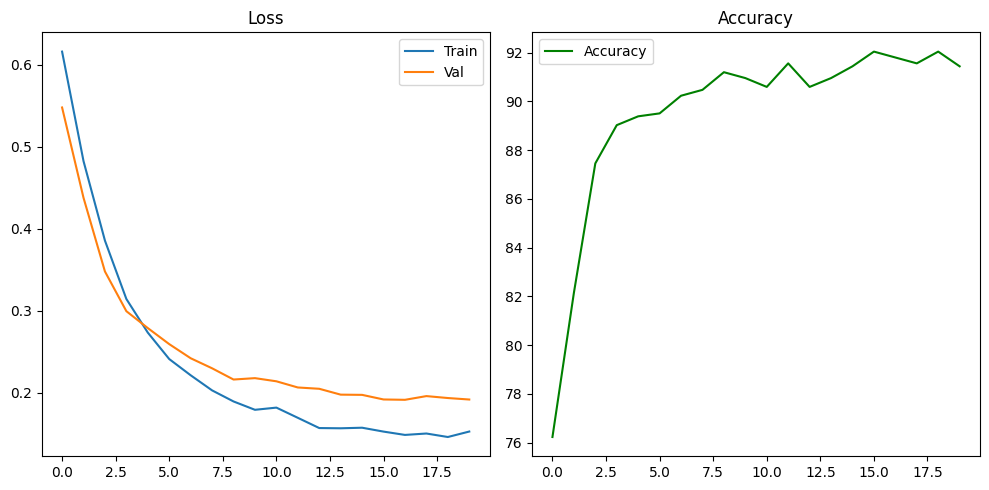

In [15]:
# 14. Plot learning curves
def plot_curves(train_losses, val_losses, accs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.title("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accs, label='Accuracy', color='green')
    plt.title("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves(train_losses, val_losses, accs)

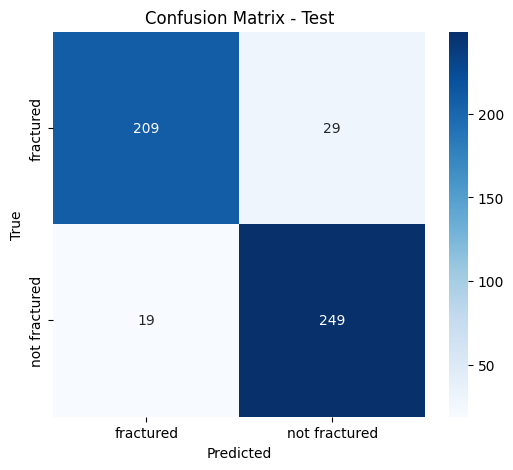

=== Classification Report ===
               precision    recall  f1-score   support

    fractured       0.92      0.88      0.90       238
not fractured       0.90      0.93      0.91       268

     accuracy                           0.91       506
    macro avg       0.91      0.90      0.90       506
 weighted avg       0.91      0.91      0.90       506

=== Overall Metrics (Macro Average) ===
Accuracy : 0.9051
Precision: 0.9062
Recall   : 0.9036
F1 Score : 0.9045


In [16]:
# 15. Test evaluation
test_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_ds = ImageFolder(test_path, transform=test_transforms)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

def get_predictions(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = get_predictions(model, test_dl)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(pd.DataFrame(cm, index=test_ds.classes, columns=test_ds.classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test")
plt.show()

# Classification Report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=test_ds.classes))

# Overall Metrics
print("=== Overall Metrics (Macro Average) ===")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, average='macro'):.4f}")

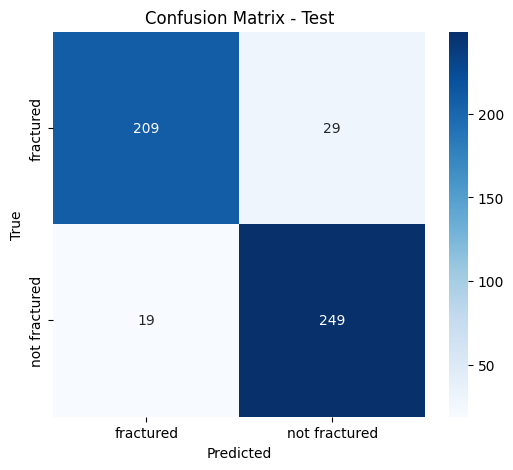

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(pd.DataFrame(cm, index=test_ds.classes, columns=test_ds.classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test")
plt.show()


In [18]:
# Classification Report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=test_ds.classes))

# Overall Metrics
print("=== Overall Metrics (Macro Average) ===")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, average='macro'):.4f}")

=== Classification Report ===
               precision    recall  f1-score   support

    fractured       0.92      0.88      0.90       238
not fractured       0.90      0.93      0.91       268

     accuracy                           0.91       506
    macro avg       0.91      0.90      0.90       506
 weighted avg       0.91      0.91      0.90       506

=== Overall Metrics (Macro Average) ===
Accuracy : 0.9051
Precision: 0.9062
Recall   : 0.9036
F1 Score : 0.9045
